In [32]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [33]:
# Load dataset
try:
    df = pd.read_csv("Customer Churn.csv")
    display(df.head())
except FileNotFoundError:
    print("Dataset file not found. Please check the file path.")

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
0,8,0.0,38.0,0,4370.0,71.0,5.0,17.0,3.0,1.0,1.0,30,197.640,177.8760,69.7640,0
1,0,0.0,39.0,0,318.0,5.0,7.0,4.0,2.0,1.0,2.0,25,46.035,41.4315,60.0000,0
2,10,0.0,37.0,0,2453.0,60.0,359.0,24.0,3.0,1.0,1.0,30,1536.520,1382.8680,203.6520,0
3,10,0.0,38.0,0,4198.0,66.0,1.0,35.0,1.0,1.0,1.0,15,240.020,216.0180,74.0020,0
4,3,0.0,38.0,0,2393.0,58.0,2.0,33.0,1.0,1.0,1.0,15,145.805,131.2245,64.5805,0


# Data Cleaning

In [34]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3164 entries, 0 to 3163
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3164 non-null   int64  
 1   Complains                3161 non-null   float64
 2   Subscription  Length     3160 non-null   float64
 3   Charge  Amount           3164 non-null   int64  
 4   Seconds of Use           3152 non-null   float64
 5   Frequency of use         3161 non-null   float64
 6   Frequency of SMS         3155 non-null   float64
 7   Distinct Called Numbers  3162 non-null   float64
 8   Age Group                3157 non-null   float64
 9   Tariff Plan              3158 non-null   float64
 10  Status                   3162 non-null   float64
 11  Age                      3164 non-null   int64  
 12  Customer Value           3156 non-null   float64
 13  FN                       3156 non-null   float64
 14  FP        

In [35]:
# sum of null values in each column
df.isnull().sum()

Call  Failure               0
Complains                   3
Subscription  Length        4
Charge  Amount              0
Seconds of Use             12
Frequency of use            3
Frequency of SMS            9
Distinct Called Numbers     2
Age Group                   7
Tariff Plan                 6
Status                      2
Age                         0
Customer Value              8
FN                          8
FP                          1
Churn                       0
dtype: int64

In [36]:
#drop rows with missing values
df = df.dropna()

In [37]:
# Check for duplicate rows in the dataset
duplicate_count = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Total Duplicate Rows in Dataset: {duplicate_count}")


Total Duplicate Rows in Dataset: 297


In [38]:
# dropping duplicate rows
df = df.drop_duplicates()

In [39]:
df.shape

(2850, 16)

# EDA (Exploratory data analysis)

In [40]:
# Display summary statistics
print(df.describe())

       Call  Failure    Complains  Subscription  Length  Charge  Amount  \
count    2850.000000  2850.000000           2850.000000     2850.000000   
mean        7.802456     0.080702             32.452982        0.974737   
std         7.326172     0.272424              8.723075        1.550618   
min         0.000000     0.000000              3.000000        0.000000   
25%         1.000000     0.000000             29.000000        0.000000   
50%         6.000000     0.000000             35.000000        0.000000   
75%        12.000000     0.000000             38.000000        2.000000   
max        36.000000     1.000000             47.000000       10.000000   

       Seconds of Use  Frequency of use  Frequency of SMS  \
count     2850.000000       2850.000000       2850.000000   
mean      4534.243158         70.484912         73.789825   
std       4199.712303         57.401512        112.062397   
min          0.000000          0.000000          0.000000   
25%       1458.7500

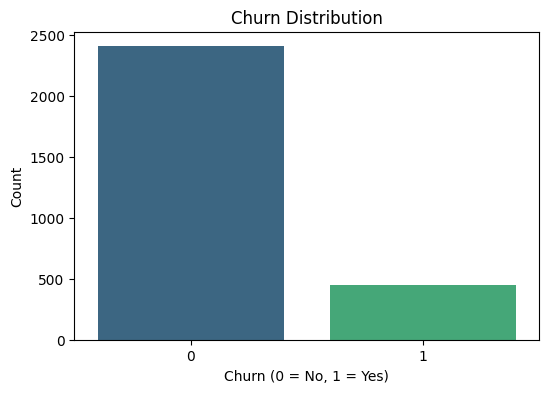

Churn Rate:
 Churn
0    84.350877
1    15.649123
Name: proportion, dtype: float64


In [41]:
# Plot Churn Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, hue='Churn', palette='viridis', legend=False)
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Calculate percentage of churned customers
churn_rate = df['Churn'].value_counts(normalize=True) * 100
print("Churn Rate:\n", churn_rate)


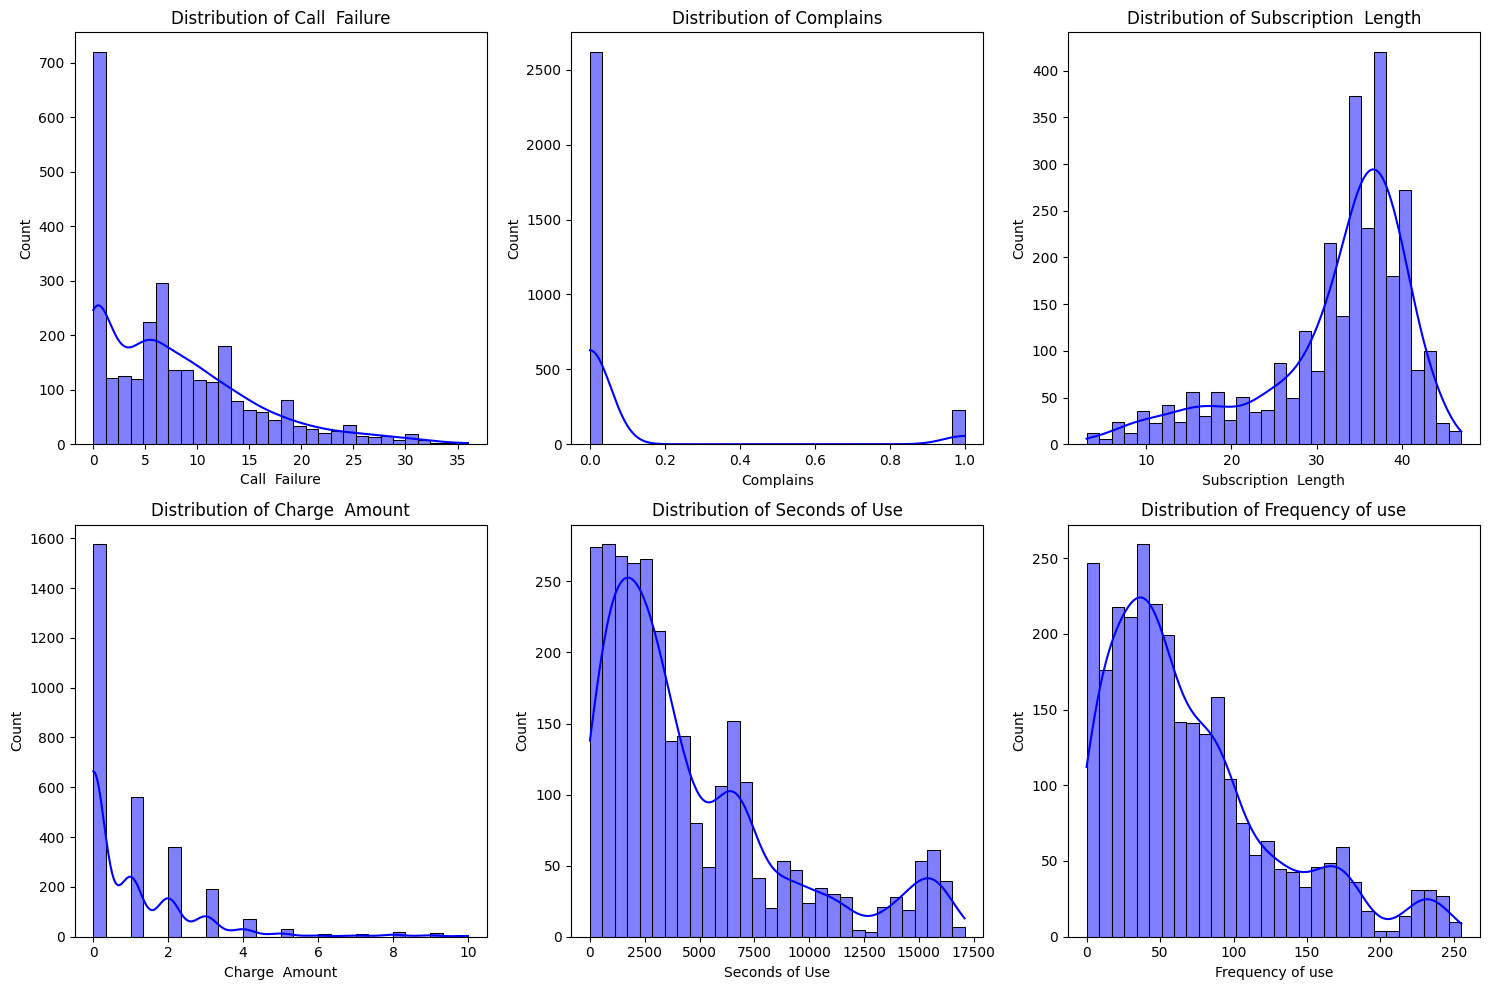

In [42]:
# Select numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

# Set up the plot grid
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features[:6]):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

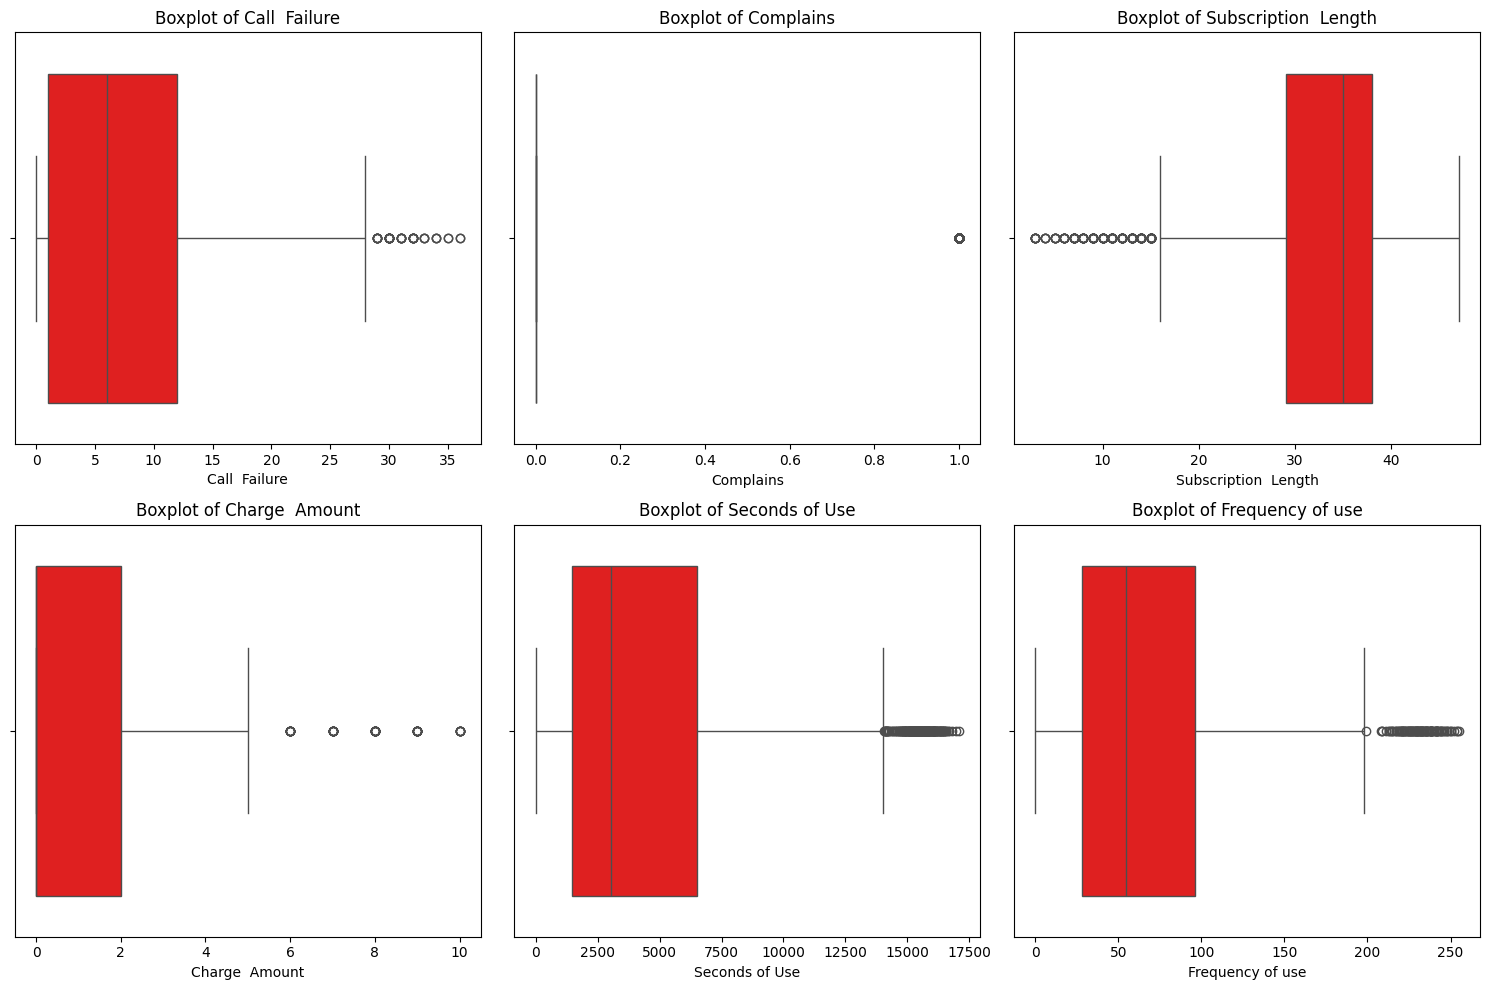

In [43]:
# Boxplots to identify outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[col], color='red')
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


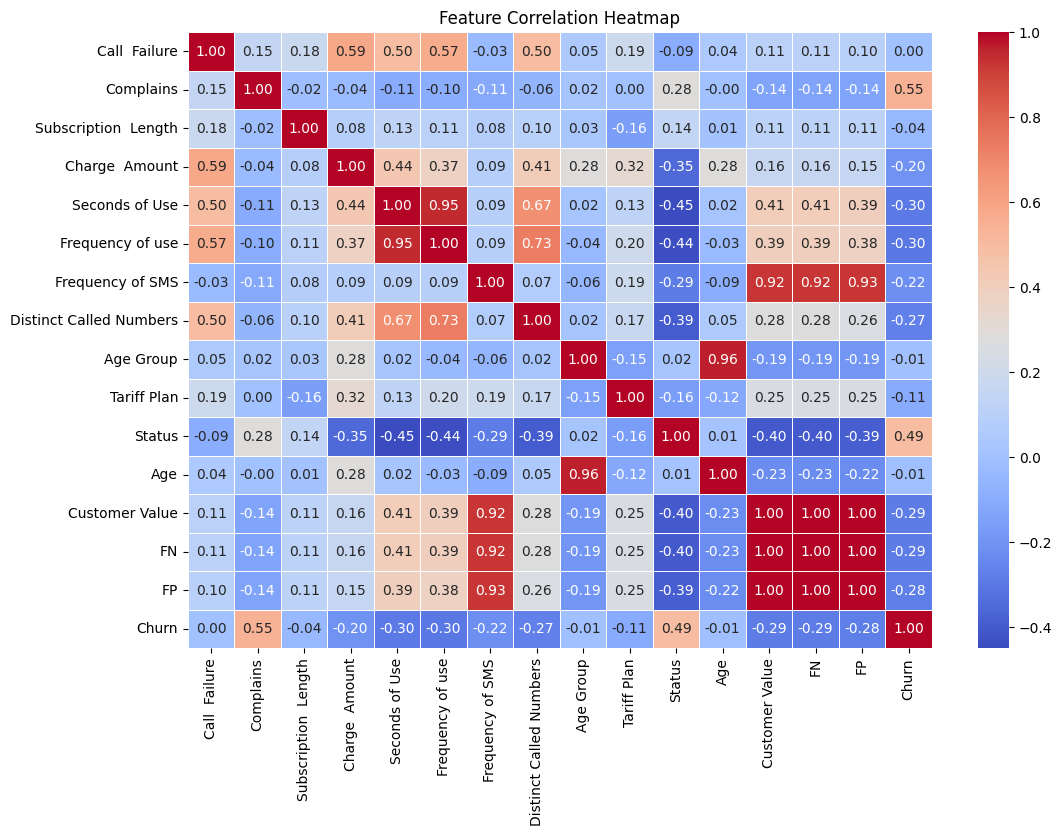

In [44]:
# Correlation Analysis using Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

As we can see the data is very much imbalanced we are using SMOTE to balance it.

In [45]:
# Define features (X) and target (y)
X = df.drop(columns=['Churn']) 
y = df['Churn'] 

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
balanced_churn_distribution = y_train_smote.value_counts(normalize=True) * 100

# Display the new distribution of churn after SMOTE
print("New Churn Distribution After SMOTE:\n", balanced_churn_distribution)


New Churn Distribution After SMOTE:
 Churn
1    50.0
0    50.0
Name: proportion, dtype: float64


# Evaluating the best model

In [46]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_classification_report = classification_report(y_test, y_pred_rf)

In [47]:
# Train XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_classification_report = classification_report(y_test, y_pred_xgb)

In [48]:
# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# Evaluate the Gradient Boosting model
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_classification_report = classification_report(y_test, y_pred_gb)

In [49]:
# Compare model performance
model_performance = {
    "Random Forest Accuracy": accuracy_score(y_test, y_pred_rf),
    "XGBoost Accuracy": accuracy_score(y_test, y_pred_xgb),
    "Gradient Boosting Accuracy": accuracy_score(y_test, y_pred_gb),
}

In [50]:
# Create a DataFrame for visualization
model_performance_df = pd.DataFrame(list(model_performance.items()), columns=["Model", "Accuracy"])

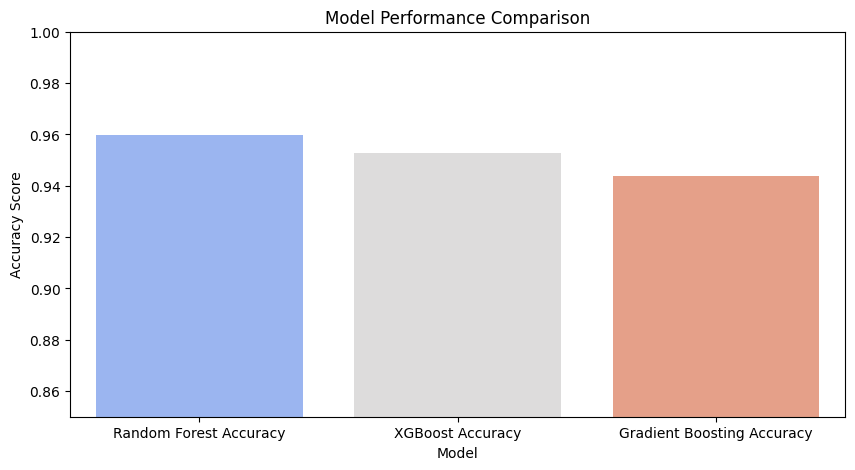

In [51]:
# Plot model performance comparison
plt.figure(figsize=(10,5))
sns.barplot(x="Model", 
            y="Accuracy", 
            data=model_performance_df, 
            hue="Model", 
            palette="coolwarm", 
            legend=False)

plt.title("Model Performance Comparison")
plt.ylabel("Accuracy Score")
plt.ylim(0.85, 1.0)
plt.show()

In [52]:
# Display the model performance comparison table
print(model_performance_df)

                        Model  Accuracy
0      Random Forest Accuracy  0.959649
1            XGBoost Accuracy  0.952632
2  Gradient Boosting Accuracy  0.943860


In [53]:
# Display classification reports
print("\nRandom Forest Performance:\n", rf_classification_report)
print("\nXGBoost Performance:\n", xgb_classification_report)
print("\nGradient Boosting Performance:\n", gb_classification_report)
print("\nModel Comparison:\n", model_performance)


Random Forest Performance:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       481
           1       0.88      0.87      0.87        89

    accuracy                           0.96       570
   macro avg       0.93      0.92      0.92       570
weighted avg       0.96      0.96      0.96       570


XGBoost Performance:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       481
           1       0.83      0.88      0.85        89

    accuracy                           0.95       570
   macro avg       0.90      0.92      0.91       570
weighted avg       0.95      0.95      0.95       570


Gradient Boosting Performance:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       481
           1       0.90      0.72      0.80        89

    accuracy                           0.94       570
   macro avg       0.93      0.85      0.88

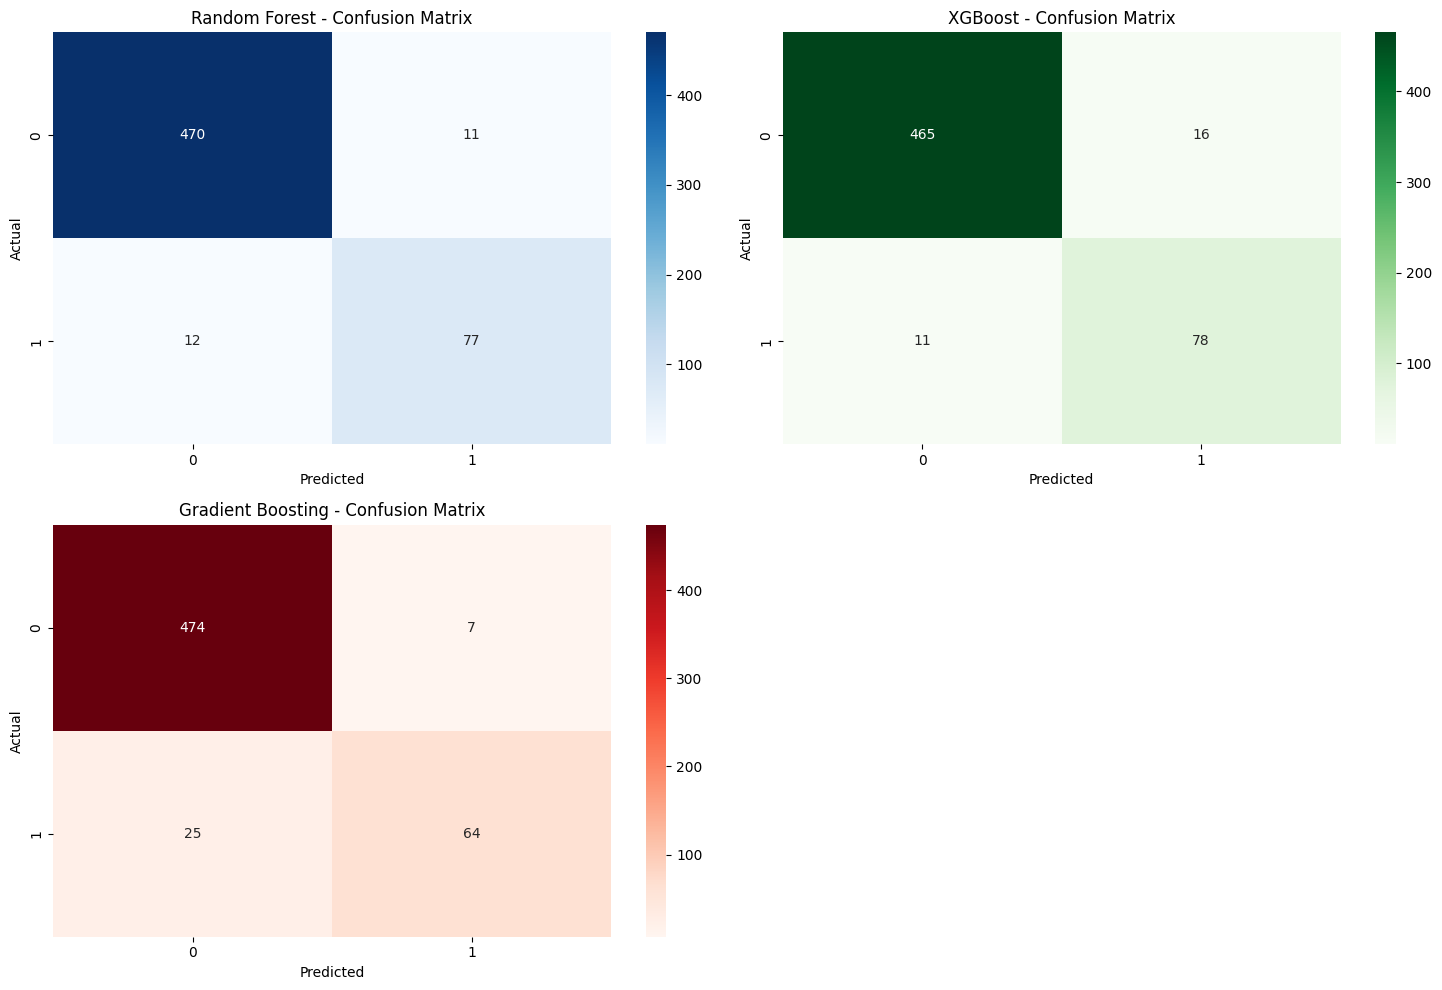

In [54]:
# Plot confusion matrix for all mopdels
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(2, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(2, 2, 3)
sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, fmt='d', cmap='Reds')
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

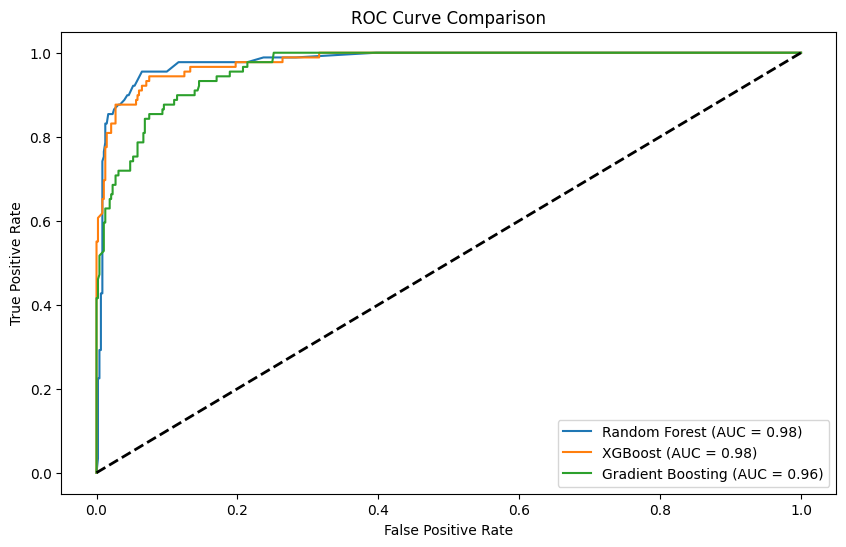


Model AUC Scores:
               Model  AUC Score
0      Random Forest   0.981102
1            XGBoost   0.979969
2  Gradient Boosting   0.964201


In [55]:
# ROC and AUC for all models
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]

xgb_model = XGBClassifier(n_estimators=50, learning_rate=0.1, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]

gb_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict_proba(X_test)[:, 1]


# Calculate ROC and AUC for each model
plt.figure(figsize=(10, 6))

auc_scores = {}

for model, y_pred, name in zip(
    [rf_model, xgb_model, gb_model],
    [y_pred_rf, y_pred_xgb, y_pred_gb],
    ["Random Forest", "XGBoost", "Gradient Boosting"]
):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    auc_scores[name] = roc_auc
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

# Convert AUC scores into a DataFrame and display
auc_df = pd.DataFrame(list(auc_scores.items()), columns=["Model", "AUC Score"])
print("\nModel AUC Scores:")
print(auc_df)


As we can see Random forest and XGBoost model have almost similat accuracy we will use hyper parameter tuning on both the model and then choose the best model

In [56]:
# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Hyperparameters for Random Forest:", rf_grid_search.best_params_)

# Train the best model with the best parameters
rf_best_model = rf_grid_search.best_estimator_
rf_best_model.fit(X_train, y_train)
y_pred_rf_best = rf_best_model.predict(X_test)

# Evaluate performance
rf_best_accuracy = accuracy_score(y_test, y_pred_rf_best)
print("Best Random Forest Accuracy:", rf_best_accuracy)


Best Hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest Accuracy: 0.956140350877193


In [57]:
# Define hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9] 
}

# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Perform Grid Search with Cross-Validation
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Hyperparameters for XGBoost:", xgb_grid_search.best_params_)

# Train the best model with the best parameters
xgb_best_model = xgb_grid_search.best_estimator_
xgb_best_model.fit(X_train, y_train)
y_pred_xgb_best = xgb_best_model.predict(X_test)

# Evaluate performance
xgb_best_accuracy = accuracy_score(y_test, y_pred_xgb_best)
print("Best XGBoost Accuracy:", xgb_best_accuracy)

Best Hyperparameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50}
Best XGBoost Accuracy: 0.9578947368421052


In [58]:
# after hyperparameter tuning choose the best model by comparing the accuracy scores and print the best model
best_model = max(rf_best_accuracy, xgb_best_accuracy)
if best_model == rf_best_accuracy:
    print("Best Model: Random Forest")
else:
    print("Best Model: XGBoost")


Best Model: XGBoost


#  Feature Importance Visualization


Top 5 Important Features - XGBoost:
                    Feature  Importance
10                   Status    0.515627
1                 Complains    0.233488
4            Seconds of Use    0.044388
2      Subscription  Length    0.037389
7   Distinct Called Numbers    0.028078


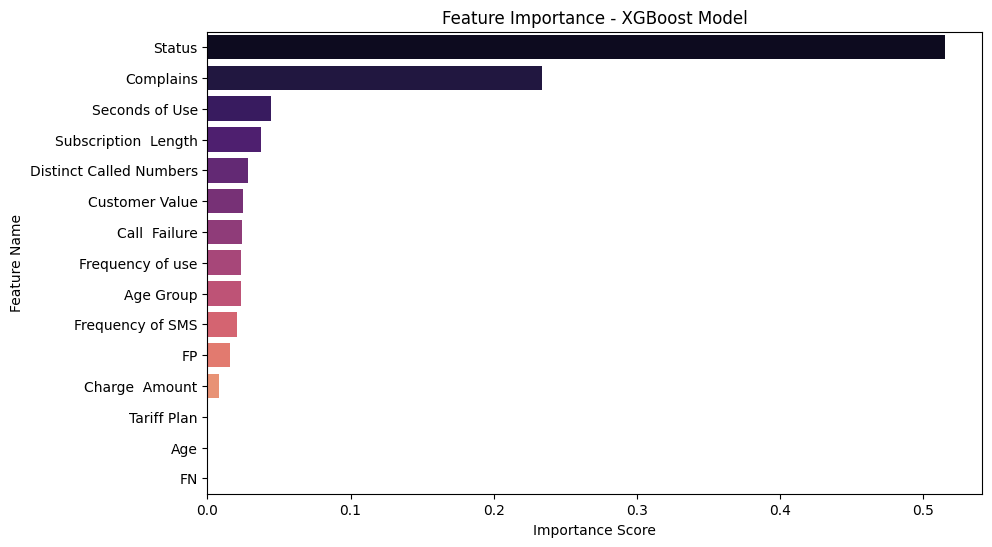

In [59]:
# Extract feature importance from XGBoost
xgb_feature_importance = xgb_best_model.feature_importances_
xgb_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_feature_importance})
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Print Top 5 Features
print("\nTop 5 Important Features - XGBoost:")
print(xgb_feature_importance_df.head())

# Plot Feature Importance - XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', 
            y='Feature', 
            data=xgb_feature_importance_df, 
            hue='Feature',
            palette='magma', 
            legend=False)
plt.title("Feature Importance - XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()


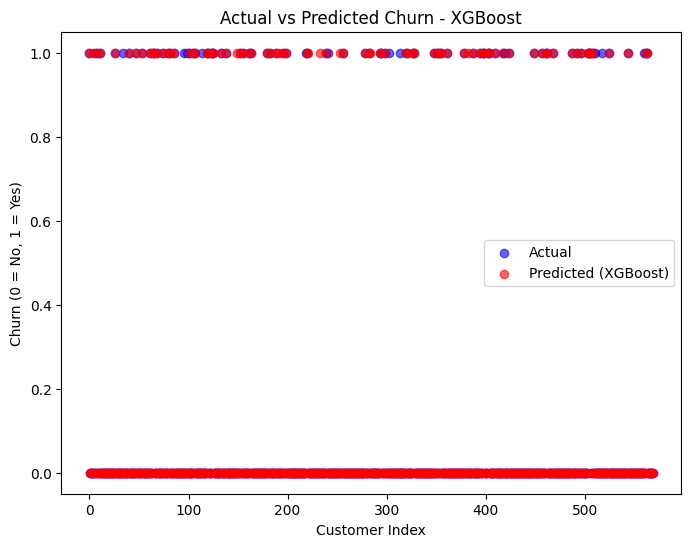

In [60]:
# Convert predictions to binary (0 or 1)
y_pred_xgb_best_binary = (y_pred_xgb_best > 0.5).astype(int)

# Scatter plot for actual vs predicted churn values
plt.figure(figsize=(8,6))
plt.scatter(range(len(y_test)), y_test, color='blue', label="Actual", alpha=0.6)
plt.scatter(range(len(y_test)), y_pred_xgb_best_binary, color='red', label="Predicted (XGBoost)", alpha=0.6)
plt.title("Actual vs Predicted Churn - XGBoost")
plt.xlabel("Customer Index")
plt.ylabel("Churn (0 = No, 1 = Yes)")
plt.legend()
plt.show()


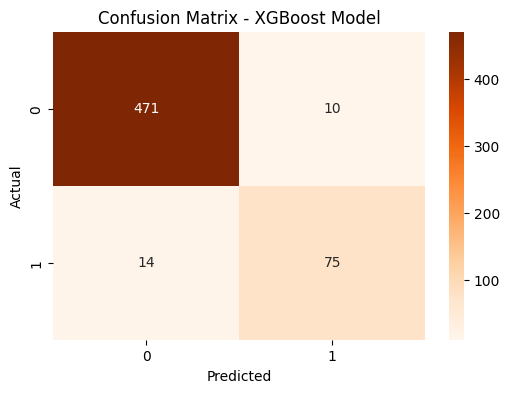

In [61]:
# Compute confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb_best_binary)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - XGBoost Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
